# Load some data

In [6]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.metrics import r2_score

In [7]:
train = pd.read_csv('../input/train.csv')  
train.head(2)

stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445

In [8]:
PATH_T = '../input/trade_train.parquet/'
PATH_B = '../input/book_train.parquet/'

In [38]:
filter = [('stock_id', '>=', '95')]

In [47]:
import pyarrow.dataset as ds

dataset = ds.dataset(PATH_T, format="parquet")

table = dataset.to_table(
    filter=ds.field("stock_id") > 95
)

trades = table.to_pandas()


ArrowInvalid: No match for FieldRef.Name(stock_id) in time_id: int16
seconds_in_bucket: int16
price: float
size: int32
order_count: int16

In [ ]:
#%%time
# dataset = pq.ParquetDataset(PATH_T, filters=filter)  #changed filters=filter to filters=filter to NONE
# table = dataset.read()
# trades = table.to_pandas()
trades['stock_id'] = trades['stock_id'].astype(np.int8)
trades.info()

ArrowNotImplementedError: Function 'greater_equal' has no kernel matching input types (int32, string)

In [ ]:
trades.columns

Index(['time_id', 'seconds_in_bucket', 'price', 'size', 'order_count',
       'stock_id'],
      dtype='object')

In [ ]:
%%time
dataset = pq.ParquetDataset(PATH_B, filters = None)  #changed filters=filter to filters=filter to NONE
books = dataset.read()
books = books.to_pandas()  # I overwrite the pyarrow table object here to save memory
books['stock_id'] = books['stock_id'].astype(np.int8)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167253289 entries, 0 to 167253288
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   time_id            int16  
 1   seconds_in_bucket  int16  
 2   bid_price1         float32
 3   ask_price1         float32
 4   bid_price2         float32
 5   ask_price2         float32
 6   bid_size1          int32  
 7   ask_size1          int32  
 8   bid_size2          int32  
 9   ask_size2          int32  
 10  stock_id           int8   
dtypes: float32(4), int16(2), int32(4), int8(1)
memory usage: 5.8 GB
CPU times: user 5.66 s, sys: 7.13 s, total: 12.8 s
Wall time: 5.14 s


In [ ]:
print(f'Found {books.time_id.nunique()} unique time ids in tardes/books.')
print(f'Found {books.stock_id.nunique()} unique stock ids in tardes/books.')

Found 3830 unique time ids in tardes/books.
Found 112 unique stock ids in tardes/books.


# Static functions

### WAP (Weighted average price)

In [ ]:
def append_wap1(df):
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1']+ df['ask_size1'])
    return df

In [ ]:
def append_wap2(df):
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2']+ df['ask_size2'])
    return df

In [ ]:
books = append_wap1(books)
books = append_wap2(books)

In [ ]:
def plot_wap(books_df, time_id, stock_id_arr):
    
    fig, ax = plt.subplots(len(stock_id_arr), 1, figsize=(18 , 16))
    fig.tight_layout(pad=2.0)
    i= 0
    
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        ax2 = ax[i].twinx()
        
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap1"], ax=ax[i], color='blue')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["ask_price1"], ax=ax[i], color='red')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["bid_price1"], ax=ax[i], color='green')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["bid_size1"] + books_df[mask]["ask_size1"], ax=ax2, color='orange')
        #sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["log_return"], ax=ax2, color='orange')
        
        ax[i].set_title(f'Stock_id: {stock_id}', loc='left', fontweight='bold')     
        ax[i].legend(['wap', 'ask_price1', 'bid_price1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax2.legend(["bid_size1 + ask_size1"], bbox_to_anchor=(1.05, 0.78), loc=2, borderaxespad=0.)
        i+=1
    plt.show()

In [ ]:
stock_id_arr = books["stock_id"].unique()
plot_wap(books, 5, stock_id_arr)

/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_89341/19937577.py:4: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(pad=2.0)


The formula of WAP can be written as below, which takes the top level price and volume information into account:

$$ WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}} $$

As you can see, if two books have both bid and ask offers on the same price level respectively, the one with more offers in place will generate a lower stock valuation, as there are more intended seller in the book, and more seller implies a fact of more supply on the market resulting in a lower stock valuation.

## Wap Balance

In [ ]:
def wap_balance(books_df):
    books_df['wap_balance'] = abs(books_df['wap1'] - books_df['wap2'])
    return books_df

In [ ]:
books = wap_balance(books)

In [ ]:
def plot_wap_balance(books_df, time_id, stock_id_arr):
    
    fig, ax = plt.subplots(len(stock_id_arr), 1, figsize=(18 , 16))
    fig.tight_layout(pad=2.0)
    i= 0
    
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        ax2 = ax[i].twinx()
        
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap1"], ax=ax[i], color='blue')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap2"], ax=ax[i], color='green')
        
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap_balance"], ax=ax2, color='orange')
        
        ax[i].set_title(f'Stock_id: {stock_id}', loc='left', fontweight='bold')     
        ax[i].legend(['wap1', 'wap2'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax2.legend(["wap_balance"], bbox_to_anchor=(1.05, 0.78), loc=2, borderaxespad=0.)
        i+=1
    plt.show()

In [ ]:
stock_id_arr = books["stock_id"].unique()
plot_wap_balance(books, 5, stock_id_arr)

/var/folders/x2/ljb2p1456lj2hps84wzsz7vh0000gn/T/ipykernel_89341/3554023651.py:4: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(pad=2.0)


KeyboardInterrupt: 

### Logarithm retrun

Returns are widely used in finance, however **log returns** are preferred whenever some mathematical modelling is required. Calling $S_t$ the price of the stock $S$ at time $t$, we can define the log return between $t_1$ and $t_2$ as:
$$
r_{t_1, t_2} = \log \left( \frac{S_{t_2}}{S_{t_1}} \right)
$$
Usually, we look at log returns over fixed time intervals, so with 10-minute log return we mean $r_t = r_{t - 10 min, t}$.

Log returns present several advantages, for example:
* Normalize data to have a better visualization and are are preferred whenever some mathematical modelling is required

To compute the log return, we can simply take **the logarithm of the ratio** between two consecutive **WAP**. The first row will have an empty return as the previous book update is unknown, **therefore the empty return data point will be dropped. We have data from "seconds_in_bucket == 1" to higher.**

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [ ]:
# books.loc[:,'log_return'] = log_return(books['wap'])
# books = books[~books['log_return'].isnull()]
# # apply log_return function and use data to create new row
books.loc[:,'log_return1'] = books.groupby(['stock_id','time_id'])['wap1'].apply(log_return)
books = books[~books['log_return1'].isnull()]
books.loc[:,'log_return2'] = books.groupby(['stock_id','time_id'])['wap2'].apply(log_return)
books = books[~books['log_return2'].isnull()]

In [ ]:
def wap_vs_logretrun(books_df, time_id, stock_id_arr):
    
    fig, ax = plt.subplots(len(stock_id_arr), 1, figsize=(18 , 16))
    fig.tight_layout(pad=2.0)
    i= 0
    
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        ax2 = ax[i].twinx()
        
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap1"], ax=ax[i], color='blue')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["log_return1"], ax=ax2, color='orange')
        
#         sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["wap2"], ax=ax[i], color='green')
#         sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["log_return2"], ax=ax2, color='purple')
        
        
        ax[i].set_title(f'Stock_id: {stock_id}', loc='left', fontweight='bold')     
        ax[i].legend(['wap1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax2.legend(["log_return1"], bbox_to_anchor=(1.05, 0.9), loc=2, borderaxespad=0.)
        i+=1
    plt.show()

In [ ]:
stock_id_arr = books["stock_id"].unique()
wap_vs_logretrun(books, 5, stock_id_arr)

# Realized volatility for stocks in features bucket
When we trade options, a valuable input to our models is the standard deviation of the stock log returns. The standard deviation will be different for log returns computed over longer or shorter intervals, for this reason it is usually normalized to a 1-year period and the annualized standard deviation is called **volatility**. 

In this competition, you will be given 10 minutes of book data and we ask you to predict what the volatility will be in the following 10 minutes. Volatility will be measured as follows:

We will compute the log returns over all consecutive book updates and we define the **realized volatility, $\sigma$,** as the squared root of the sum of squared log returns.
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$
Where we use **WAP** as price of the stock to compute log returns.

We are not annualizing the volatility and we are assuming that log returns have 0 mean.

In this competition, our target is to predict short-term realized volatility. Although the order book and trade data for the target cannot be shared, we can still present the realized volatility calculation using the feature data we provided. 

As realized volatility is a statistical measure of price changes on a given stock, to calculate the price change we first need to have a stock valuation at the fixed interval (1 second). We will use weighted averaged price, or WAP, of the order book data we provided.

In [ ]:
def realized_volatility(books_df, time_id, stock_id_arr):
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        
        realized_vol1 = np.sqrt(np.sum(books_df[mask]['log_return1']**2))
        realized_vol2 = np.sqrt(np.sum(books_df[mask]['log_return2']**2))
        
        print(f'Realized volatility1 for stock_id {stock_id} on time_id {time_id} is {realized_vol1}')
        print(f'Realized volatility2 for stock_id {stock_id} on time_id {time_id} is {realized_vol2}')

In [ ]:
stock_id_arr = books["stock_id"].unique()
realized_volatility(books, 5, stock_id_arr)

Realized volatility1 for stock_id 96 on time_id 5 is 0.005654689855873585
Realized volatility2 for stock_id 96 on time_id 5 is 0.006533394567668438
Realized volatility1 for stock_id 97 on time_id 5 is 0.007263049948960543
Realized volatility2 for stock_id 97 on time_id 5 is 0.012585372664034367
Realized volatility1 for stock_id 98 on time_id 5 is 0.00413387781009078
Realized volatility2 for stock_id 98 on time_id 5 is 0.005837624426931143
Realized volatility1 for stock_id 99 on time_id 5 is 0.00208292412571609
Realized volatility2 for stock_id 99 on time_id 5 is 0.0023660820443183184


In [ ]:
def log_return_hist(books_df, time_id, stock_id_arr):
    fig, ax = plt.subplots(len(stock_id_arr), 1, figsize=(8 , 20))
    fig.tight_layout(pad=4.0)
    
    i= 0
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        realized_vol1 = np.sqrt(np.sum(books_df[mask]['log_return1']**2))
        
        sns.histplot(data=books[mask]["log_return1"], ax= ax[i])
        _std = np.std(books[mask]["log_return1"])
        ax[i].set_title(f'Realized volatility1 for stock_id {stock_id} on time_id {time_id} is {round(realized_vol1, 5)}, teh std is: {round(_std, 5)}',
                        loc='left', fontweight='bold')     
        i+=1
    
    plt.show()

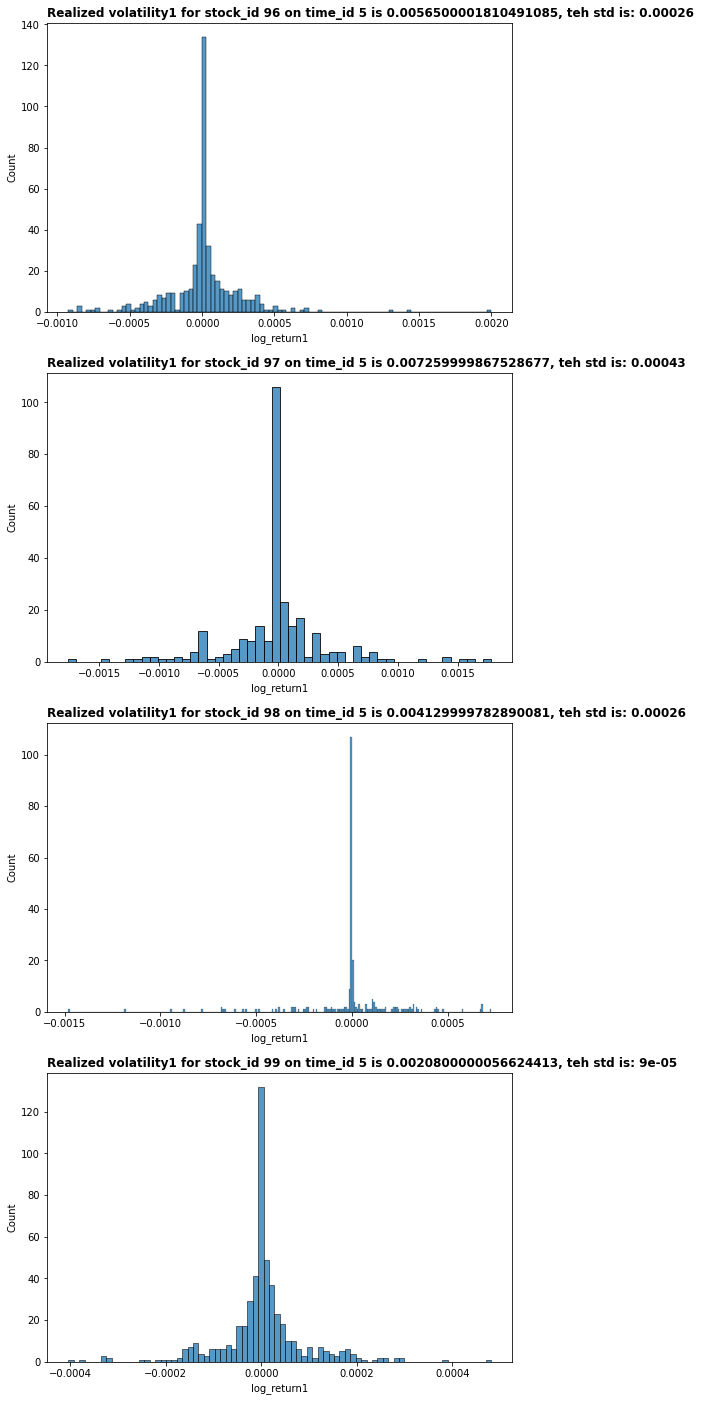

In [ ]:
stock_id_arr = books["stock_id"].unique()
log_return_hist(books, 5, stock_id_arr)

1. **If the Standard deviation is lower, the realized volatility is lower.**
2. **If the Standard deviation is higher, the realized voaltility is higher.**

# Trades

In [ ]:
trades.loc[:,'log_return'] = trades.groupby(['stock_id','time_id'])['price'].apply(log_return)
trades = trades[~trades['log_return'].isnull()]

In [ ]:
trades.loc[:,'amount'] = trades['price']*trades['size']

In [ ]:
trades

time_id  seconds_in_bucket     price  size  order_count  stock_id  \
1              5                  2  1.001410   162           10        96   
2              5                  4  1.001434    22            4        96   
3              5                  9  1.001109    47            6        96   
4              5                 23  1.000990    57            7        96   
5              5                 26  1.000747     6            2        96   
...          ...                ...       ...   ...          ...       ...   
1218388    32767                570  0.999932   100            1        99   
1218389    32767                575  0.999932   100            1        99   
1218390    32767                579  0.999797   300            3        99   
1218391    32767                584  0.999854   172            2        99   
1218392    32767                592  0.999662   400            5        99   

         log_return      amount  
1          0.000193  162.228378  
2          0.000024   22.031540  
3         -0.000325   47.052105  
4         -0.000118   57.056446  
5         -0.000243    6.004485  
...             ...         ...  
1218388    0.000135   99.993233  
1218389    0.000000   99.993233  
1218390   -0.000135  299.939117  
1218391    0.000057  171.974838  
1218392   -0.000192  399.864716  

[1203073 rows x 8 columns]

In [ ]:
def amount_vs_logretrun(books_df, time_id, stock_id_arr):
    
    fig, ax = plt.subplots(len(stock_id_arr), 1, figsize=(18 , 16))
    fig.tight_layout(pad=2.0)
    i= 0
    
    for stock_id in stock_id_arr:
        mask = np.logical_and(books_df["stock_id"]==stock_id, books_df["time_id"]==time_id)
        ax2 = ax[i].twinx()
        
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["amount"], ax=ax[i], color='blue')
        sns.lineplot(x=books_df[mask]["seconds_in_bucket"], y=books_df[mask]["log_return"], ax=ax2, color='orange')
        
        ax[i].set_title(f'Stock_id: {stock_id}', loc='left', fontweight='bold')     
        ax[i].legend(['amount'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax2.legend(["log_return1"], bbox_to_anchor=(1.05, 0.9), loc=2, borderaxespad=0.)
        i+=1
    plt.show()

In [ ]:
trades_id_arr = trades["stock_id"].unique()
amount_vs_logretrun(trades, 5, stock_id_arr)

In [ ]:
def tendency(price, vol):    
    df_diff = np.diff(price)
    val = (df_diff/price[1:])*100
    power = np.sum(val*vol[1:])
    return(power)

In [ ]:
mask = np.logical_and(trades["stock_id"]==98, trades["time_id"]==5)
tendency(trades[mask]["price"].values, trades[mask]['size'].values)

-27.686525619064923